# Tutorial

This tutorial demonstrates the steps of the algorithm that eventually will constitute the automated process of clustering target regions according to sections, and counting the members of each cluster. The purpose of the tutorial is to motivate the steps included in the algorithm.

The algorithm steps included in this tutorial can be summarized as
```
1. Segmentation of reference image.
2. Segmentation of samples image.
3. Segmentation of the clusters image.
4. Compute target image by overlaying the reference and samples images, while 
   retaining only the overlapping regions.
5. Clustering target regions according to shortest euclidean distance to cluster regions. 
```

The source code of various functions are located in the directory modules.

By Severin E. R. Langberg

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

from skimage import io
from skimage.measure import regionprops
from skimage.measure import find_contours
from skimage.segmentation import join_segmentations

from filters import threshold, binarize
from clustering import nearest_region_clustering
from measure import region_selection, region_labeling
from segmentation import select_targets, clear_borders

%matplotlib inline

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'black'

io.use_plugin('tifffile')

## Segmenting the reference image

Load reference image

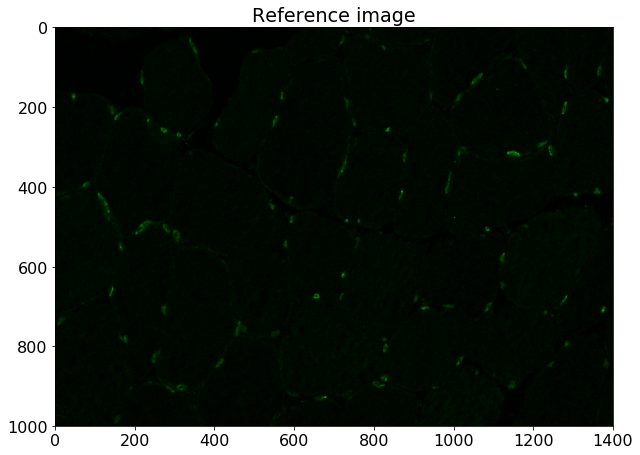

In [4]:
ref_image = io.imread('./../../nih_material/images/train/refr_train.tif')
#ref_image = io.imread('./../../nih_material/images/orig/targets_v2.tif')

plt.figure(figsize=(10, 10))
plt.imshow(ref_image);
plt.title('Reference image');

Display histograms

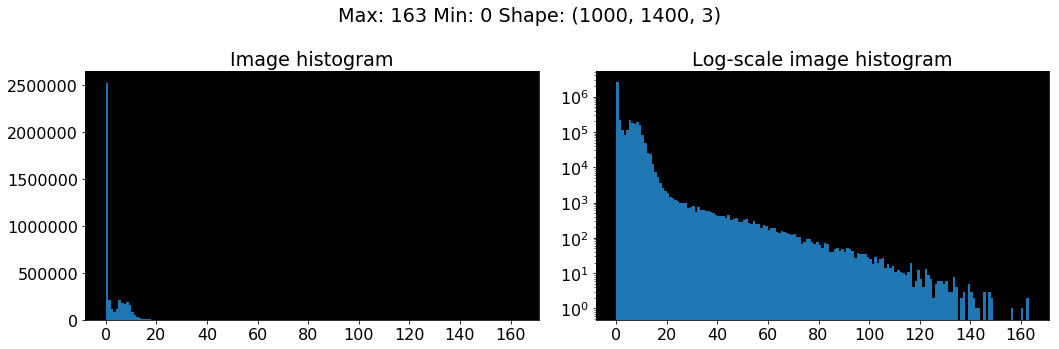

In [42]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Max: {} Min: {} Shape: {}'.format(np.max(ref_image),
                                                np.min(ref_image),
                                                np.shape(ref_image)))

ax[0].hist(ref_image.flatten(), bins=ref_image.max());
ax[0].set_title('Image histogram');
ax[1].hist(ref_image.flatten(), bins=ref_image.max(), log=True);
ax[1].set_title('Log-scale image histogram');

plt.tight_layout()
fig.subplots_adjust(top=0.80)

Comparing thresholding algorithms

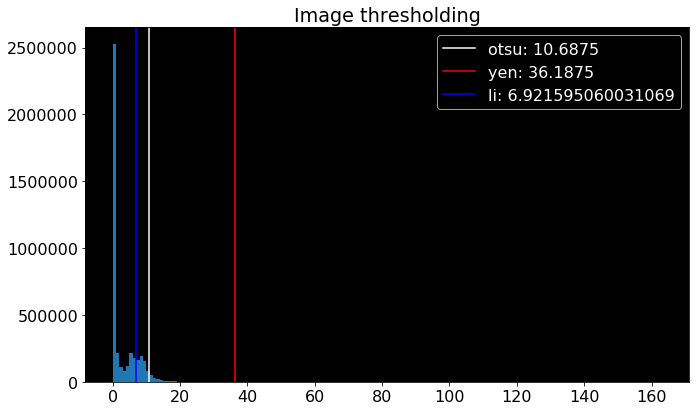

In [54]:
thresholds = {
    'otsu': threshold(ref_image, algorithm='otsu'), 
    'yen': threshold(ref_image, algorithm='yen'),
    'li': threshold(ref_image, algorithm='li')
}

plt.figure(figsize=(10, 6))
plt.title('Image thresholding')

plt.hist(ref_image.flatten(), bins=ref_image.max());

colors = ['w', 'r', 'b']
for num, thresh in enumerate(thresholds.values()):
    plt.axvline(x=thresh, color=colors[num])
    
legend = plt.legend(
    ['otsu: {}'.format(thresholds['otsu']), 
     'yen: {}'.format(thresholds['yen']), 
     'li: {}'.format(thresholds['li'])]
)
plt.setp(legend.get_texts(), color='w')

plt.tight_layout()

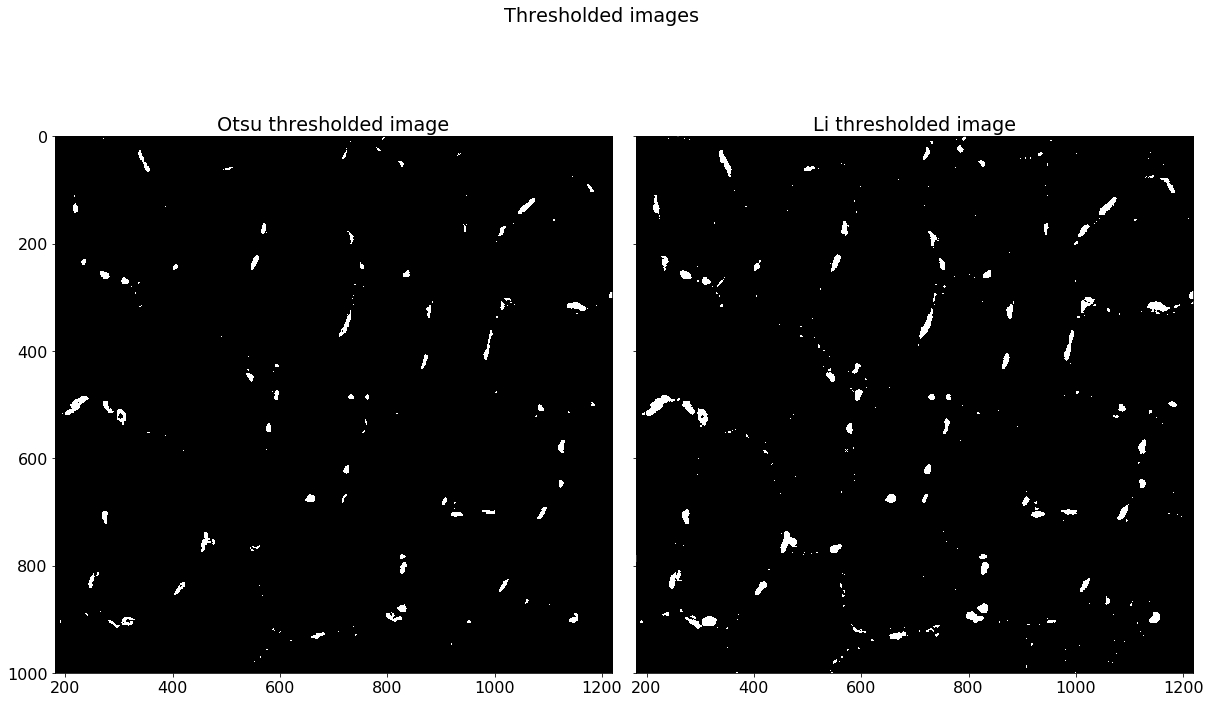

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 10), sharey=True)
fig.suptitle('Thresholded images')

ax[0].imshow(binarize(ref_image, thresholds['otsu']), cmap=plt.cm.gray);
ax[0].set_title('Otsu thresholded image');
ax[1].imshow(binarize(ref_image, thresholds['li']), cmap=plt.cm.gray);
ax[1].set_title('Li thresholded image');

plt.tight_layout()
fig.subplots_adjust(top=0.80)

It appears to be more noise in *Li* thresholded image.

In [49]:
ref_binary = binarize(ref_image, thresholds['otsu'])

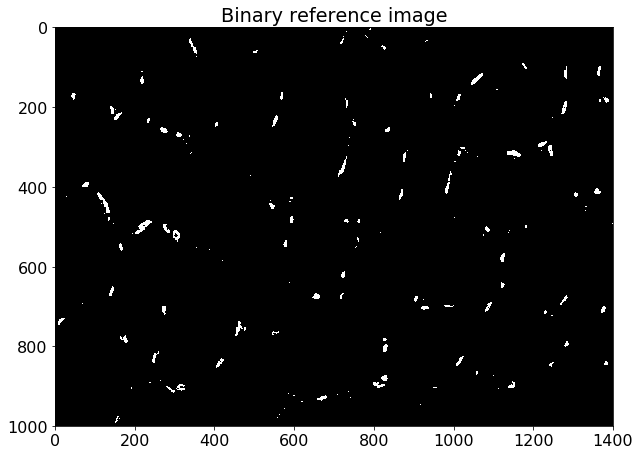

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(ref_binary, cmap=plt.cm.gray);
plt.title('Binary reference image');

Remove image artifacts with areas less than a specified limit.

In [ ]:
ref_filtered = region_selection(ref_binary, min_area=15)

plt.figure(figsize=(10, 10))
plt.imshow(ref_filtered, cmap=plt.cm.gray);
plt.title('Filtered reference  image');

Compare the binary version of the filtered reference image to the original 

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(ref_image, cmap=plt.cm.gray);
ax[0].set_title('Original reference image');
ax[1].imshow(ref_filtered, cmap=plt.cm.gray)
ax[1].set_title('Filtered reference image');

## Segmenting the samples image

Load samples image

In [ ]:
#samples_image = io.imread('./../../nih_images/samples_train.tif')
samples_image = io.imread('./../../NIH/images/orig/samples_v2.tif')

plt.figure(figsize=(10, 10))
plt.imshow(samples_image);
plt.title('Samples image');

Image egmentation and binarization by thresholding

In [ ]:
samples_binary = threshold(samples_image, algorithm='otsu')

plt.figure(figsize=(10, 10))
plt.imshow(samples_binary, cmap=plt.cm.gray);
plt.title('Binary samples image');

Comparing to the original samples image

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(samples_image, cmap=plt.cm.gray);
ax[0].set_title('Original samples image');
ax[1].imshow(samples_binary, cmap=plt.cm.gray)
ax[1].set_title('Binary samples image');

It is unecessary to filter noise from the samples image as long as the reference image is representative. Only the regions common in both the reference and the samples image will be retained during target region filtering. This means that any noise in the samples image will be discarded unless it overlaps with any region in the reference image.

## Segmenting the clusters image 

Load image

In [ ]:
#clusters = io.imread('./../../nih_images/clusters_train.tif')
clusters = io.imread('./../../NIH/images/orig/membrane_v2.tif')


plt.figure(figsize=(10, 10))
plt.imshow(clusters);
plt.title('Clusters image');

Image egmentation and binarization by thresholding

In [ ]:
clusters_binary = threshold(clusters, algorithm='yen')

plt.figure(figsize=(10, 10))
plt.imshow(clusters_binary, cmap=plt.cm.gray);
plt.title('Binary clusters');

Comparing the binary clusters image to the original


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(clusters, cmap=plt.cm.gray);
ax[0].set_title('Original clusters');
ax[1].imshow(clusters_binary, cmap=plt.cm.gray)
ax[1].set_title('Binary clusters');

Clear the image borders and broken membranes in the outer region

In [ ]:
clusters_cleared = clear_borders(clusters_binary)

plt.figure(figsize=(10, 10))
plt.imshow(clusters_cleared, cmap=plt.cm.gray);
plt.title('Cleared clusters');

Remove image artifacts with areas less than a specified limit.

In [ ]:
clusters_filtered = region_selection(clusters_cleared, min_area=15000, max_area=400000)

plt.figure(figsize=(10, 10))
plt.imshow(clusters_filtered, cmap=plt.cm.gray);
plt.title('Filtered clusters');

Compare to cleared cluster image

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(clusters_cleared, cmap=plt.cm.gray);
ax[0].set_title('Cleared clusters');
ax[1].imshow(clusters_filtered, cmap=plt.cm.gray)
ax[1].set_title('Filtered clusters');

## Target regions filtering

Compute an image by comparing the segmented regions in the reference and samples image while retaining only the overlapping regions.

In [ ]:
masked = join_segmentations(ref_filtered, samples_binary,)
masks = np.unique(masked)
classes = np.linspace(np.min(ref_filtered), np.max(ref_binary), masks.size)

overlayed = np.zeros_like(ref_filtered, dtype=int)

for num, mask in enumerate(masks):
    overlayed[masked == mask] = int(classes[num])

plt.figure(figsize=(10, 10))
plt.imshow(overlayed, cmap=plt.cm.viridis);
plt.title('Overlaying the reference and target image.');

where:
* purple = background
* teal = samples regions
* green = reference regions
* yellow = samples + reference regions

Computing the image containing only the yellow regions as image target regions

In [ ]:
targets = select_targets(ref_filtered, samples_binary)

plt.figure(figsize=(10, 10))
plt.imshow(targets, cmap=plt.cm.gray);
plt.title('Target regions.');

Comparing to the overlayed image

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(overlayed, cmap=plt.cm.viridis);
ax[0].set_title('Overlaying the reference and target image.');
ax[1].imshow(targets , cmap=plt.cm.gray)
ax[1].set_title('Target regions.');

The regions of the binary image represents the target regions that will be assigned to clusters.

## Clustering

Labelling the cluster and target images

In [ ]:
targets_labeled = region_labeling(targets)
clusters_labeled = region_labeling(clusters_filtered)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(targets_labeled, cmap=plt.cm.hot);
ax[0].set_title('Labeled targets.');
ax[1].imshow(clusters_labeled , cmap=plt.cm.hot)
ax[1].set_title('Labeled clusters.');

Computing target region centroids and cluster region coordinates

In [ ]:
target_props = regionprops(targets_labeled)
cluster_props = regionprops(clusters_labeled)

target_centroids = OrderedDict()
for num, props in enumerate(target_props):
    target_id = num + 1
    target_centroids[target_id] = (props.centroid)
    
region_coords = OrderedDict()  
for num, props in enumerate(cluster_props):
    region_id = num + 1
    region_coords[region_id] = props.coords

Visualizing the centroids overlaying the target regions

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(targets, interpolation='nearest', cmap=plt.cm.viridis)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'g.', markersize=10)
    
ax.set_title('Target region centroids');

Displaying the centroids of each target region in addition to labeled cluster regions

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_labeled, interpolation='nearest', cmap=plt.cm.viridis)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'w.', markersize=10)
    
ax.set_title('Target centroids and cluster regions');

Target centroid positions overlaying the binary version of the thresholded cluster image.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_binary, interpolation='nearest', cmap=plt.cm.gray)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'r.', markersize=10)
    
ax.set_title('Target centroids and cluster regions');

In [ ]:
clusters = nearest_region_clustering(target_centroids, region_coords, distance_thresh=15)

Filtering of target values due to distance threshold

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_labeled, interpolation='nearest', cmap=plt.cm.viridis)

for region_id, centroids in clusters.items():
    if not centroids:
        continue
    else:
        x, y = list(zip(*centroids))
        ax.scatter(y, x, c='w')
        
ax.set_title('Clustered target regions and cluster regions');

The clustering results

In [ ]:
#for region_id, centroids in clusters.items():
#    print('Region {}: {} targets'.format(region_id, len(centroids)))

The total number of targets in the image

In [ ]:
np.sum([len(centroids) for centroids in clusters.values()])